# TimesNet Tutorial
**Set-up instructions:** this notebook give a tutorial on the using of `TimesNet`.
## Packages import and prepare arguments

In [1]:
import os
import time

import numpy as np
import torch.cuda
from sklearn.metrics import precision_recall_fscore_support

from tsadlib import ConfigType
from tsadlib import EarlyStopping
from tsadlib import TimesNet
from tsadlib import data_provider
from tsadlib.utils.constants import PROJECT_ROOT

if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f'use device: {device}')
device = torch.device(device)

DATASET_ROOT = '/Users/liuzhenzhou/Documents/backup/datasets/anomaly_detection/npy'
DATASET_TYPE = 'MSL'

CHECKPOINTS = os.path.join(PROJECT_ROOT, 'checkpoints')

args = ConfigType(**{
    'root_path': os.path.join(DATASET_ROOT, DATASET_TYPE),
    'dataset': DATASET_TYPE,
    'seq_len': 100,
    'batch_size': 32,
    'num_workers': 10,
    'top_k': 3,
    'd_model': 8,
    'd_ff': 16,
    'num_kernels': 6,
    'e_layers': 1,
    'enc_in': 55,
    'c_out': 55,
    'dropout': 0.1,
    'embed_type': 'timeF',
    'freq': 'h',
    'anomaly_ratio': 1,
    'train_epochs': 1,
    'learning_rate': 0.0001
})

train_data, train_loader = data_provider(args, flag='train')
test_data, test_loader = data_provider(args, flag='test')



use device: mps
2025-03-18 21:29:31.281 | INFO     | tsadlib.data_provider.datasets.msl:__init__:71 - test set's shape: (73729, 55)
2025-03-18 21:29:31.281 | INFO     | tsadlib.data_provider.datasets.msl:__init__:72 - train set's shape: (58317, 55)
2025-03-18 21:29:31.311 | INFO     | tsadlib.data_provider.datasets.msl:__init__:71 - test set's shape: (73729, 55)
2025-03-18 21:29:31.311 | INFO     | tsadlib.data_provider.datasets.msl:__init__:72 - train set's shape: (58317, 55)


## 模型定义和训练

In [2]:
# 初始化模型
model = TimesNet(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = torch.nn.MSELoss()
early_stopping = EarlyStopping(patience=args.patience)
train_steps = len(train_loader)
time_now = time.time()

# 训练循环
for epoch in range(1):
    model.train()
    train_loss = []
    iter_count = 0
    epoch_time = time.time()

    for i, (batch_x, batch_y) in enumerate(train_loader):
        iter_count += 1
        optimizer.zero_grad()
        batch_x = batch_x.float().to(device)

        # 前向传播
        outputs = model(batch_x)
        loss = criterion(outputs, batch_x)

        if (i + 1) % 100 == 0:
            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((args.train_epochs - epoch) * train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        # 反向传播
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(train_loss)

    # 早停检查
    if early_stopping(np.mean(train_loss), model, os.path.join(PROJECT_ROOT, 'checkpoints'), 'MSL'):
        print("Early stopping triggered")
        break

	iters: 100, epoch: 1 | loss: 0.8183778
	speed: 0.1567s/iter; left time: 269.7547s
	iters: 200, epoch: 1 | loss: 0.6049901
	speed: 0.0433s/iter; left time: 70.1092s
	iters: 300, epoch: 1 | loss: 1.1357583
	speed: 0.0443s/iter; left time: 67.4476s
	iters: 400, epoch: 1 | loss: 0.5797690
	speed: 0.0431s/iter; left time: 61.2801s
	iters: 500, epoch: 1 | loss: 0.5537007
	speed: 0.0433s/iter; left time: 57.1627s
	iters: 600, epoch: 1 | loss: 1.8285886
	speed: 0.0430s/iter; left time: 52.5313s
	iters: 700, epoch: 1 | loss: 0.6637688
	speed: 0.0433s/iter; left time: 48.5540s
	iters: 800, epoch: 1 | loss: 0.4112437
	speed: 0.0431s/iter; left time: 44.0385s
	iters: 900, epoch: 1 | loss: 1.2431158
	speed: 0.0434s/iter; left time: 40.0109s
	iters: 1000, epoch: 1 | loss: 0.2771469
	speed: 0.0433s/iter; left time: 35.5350s
	iters: 1100, epoch: 1 | loss: 0.6931689
	speed: 0.0434s/iter; left time: 31.2742s
	iters: 1200, epoch: 1 | loss: 0.5000784
	speed: 0.0432s/iter; left time: 26.8487s
	iters: 1300

## 模型评估

In [6]:
from torch import nn

model.eval()
test_scores = []
test_labels = []
anomaly_criterion = nn.MSELoss(reduce=False)

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.float().to(device)
        outputs = model(batch_x)

        # 计算重构误差作为异常分数
        score = torch.mean(anomaly_criterion(outputs, batch_x), dim=-1)
        test_scores.append(score.detach().cpu().numpy())
        test_labels.append(batch_y)

# 将所有batch的分数和标签合并
test_scores = np.concatenate(test_scores, axis=0)  # [total_samples, seq_len]
test_labels = np.concatenate(test_labels, axis=0)  # [total_samples, seq_len]

# 将序列维度展平
flat_scores = test_scores.reshape(-1)
flat_labels = test_labels.reshape(-1)

# 使用不同百分位数作为阈值进行评估
percentiles = [90, 95, 99]
best_f1 = 0
best_threshold = None
best_results = None
anomaly_criterion = nn.MSELoss(reduce=False)

for p in percentiles:
    threshold = np.percentile(flat_scores, p)
    pred_labels = (flat_scores > threshold).astype(int)

    # 计算评估指标
    precision, recall, f1, _ = precision_recall_fscore_support(flat_labels, pred_labels, average='binary')

    print(f"\n阈值百分位: {p}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        best_results = (precision, recall, f1)

print("\n最佳结果:")
print(f"最佳阈值: {best_threshold:.4f}")
print(f"Precision: {best_results[0]:.4f}")
print(f"Recall: {best_results[1]:.4f}")
print(f"F1-score: {best_results[2]:.4f}")

/Users/liuzhenzhou/anaconda3/envs/python313/lib/python3.13/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))



阈值百分位: 90%
Precision: 0.1341
Recall: 0.1271
F1-score: 0.1305

阈值百分位: 95%
Precision: 0.1862
Recall: 0.0883
F1-score: 0.1198

阈值百分位: 99%
Precision: 0.2685
Recall: 0.0255
F1-score: 0.0465

最佳结果:
最佳阈值: 0.7973
Precision: 0.1341
Recall: 0.1271
F1-score: 0.1305


## 可视化结果

/Users/liuzhenzhou/anaconda3/envs/python313/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24322 (\N{CJK UNIFIED IDEOGRAPH-5F02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/liuzhenzhou/anaconda3/envs/python313/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/liuzhenzhou/anaconda3/envs/python313/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/liuzhenzhou/anaconda3/envs/python313/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/liuzhenzhou/anaconda3/envs/python313/

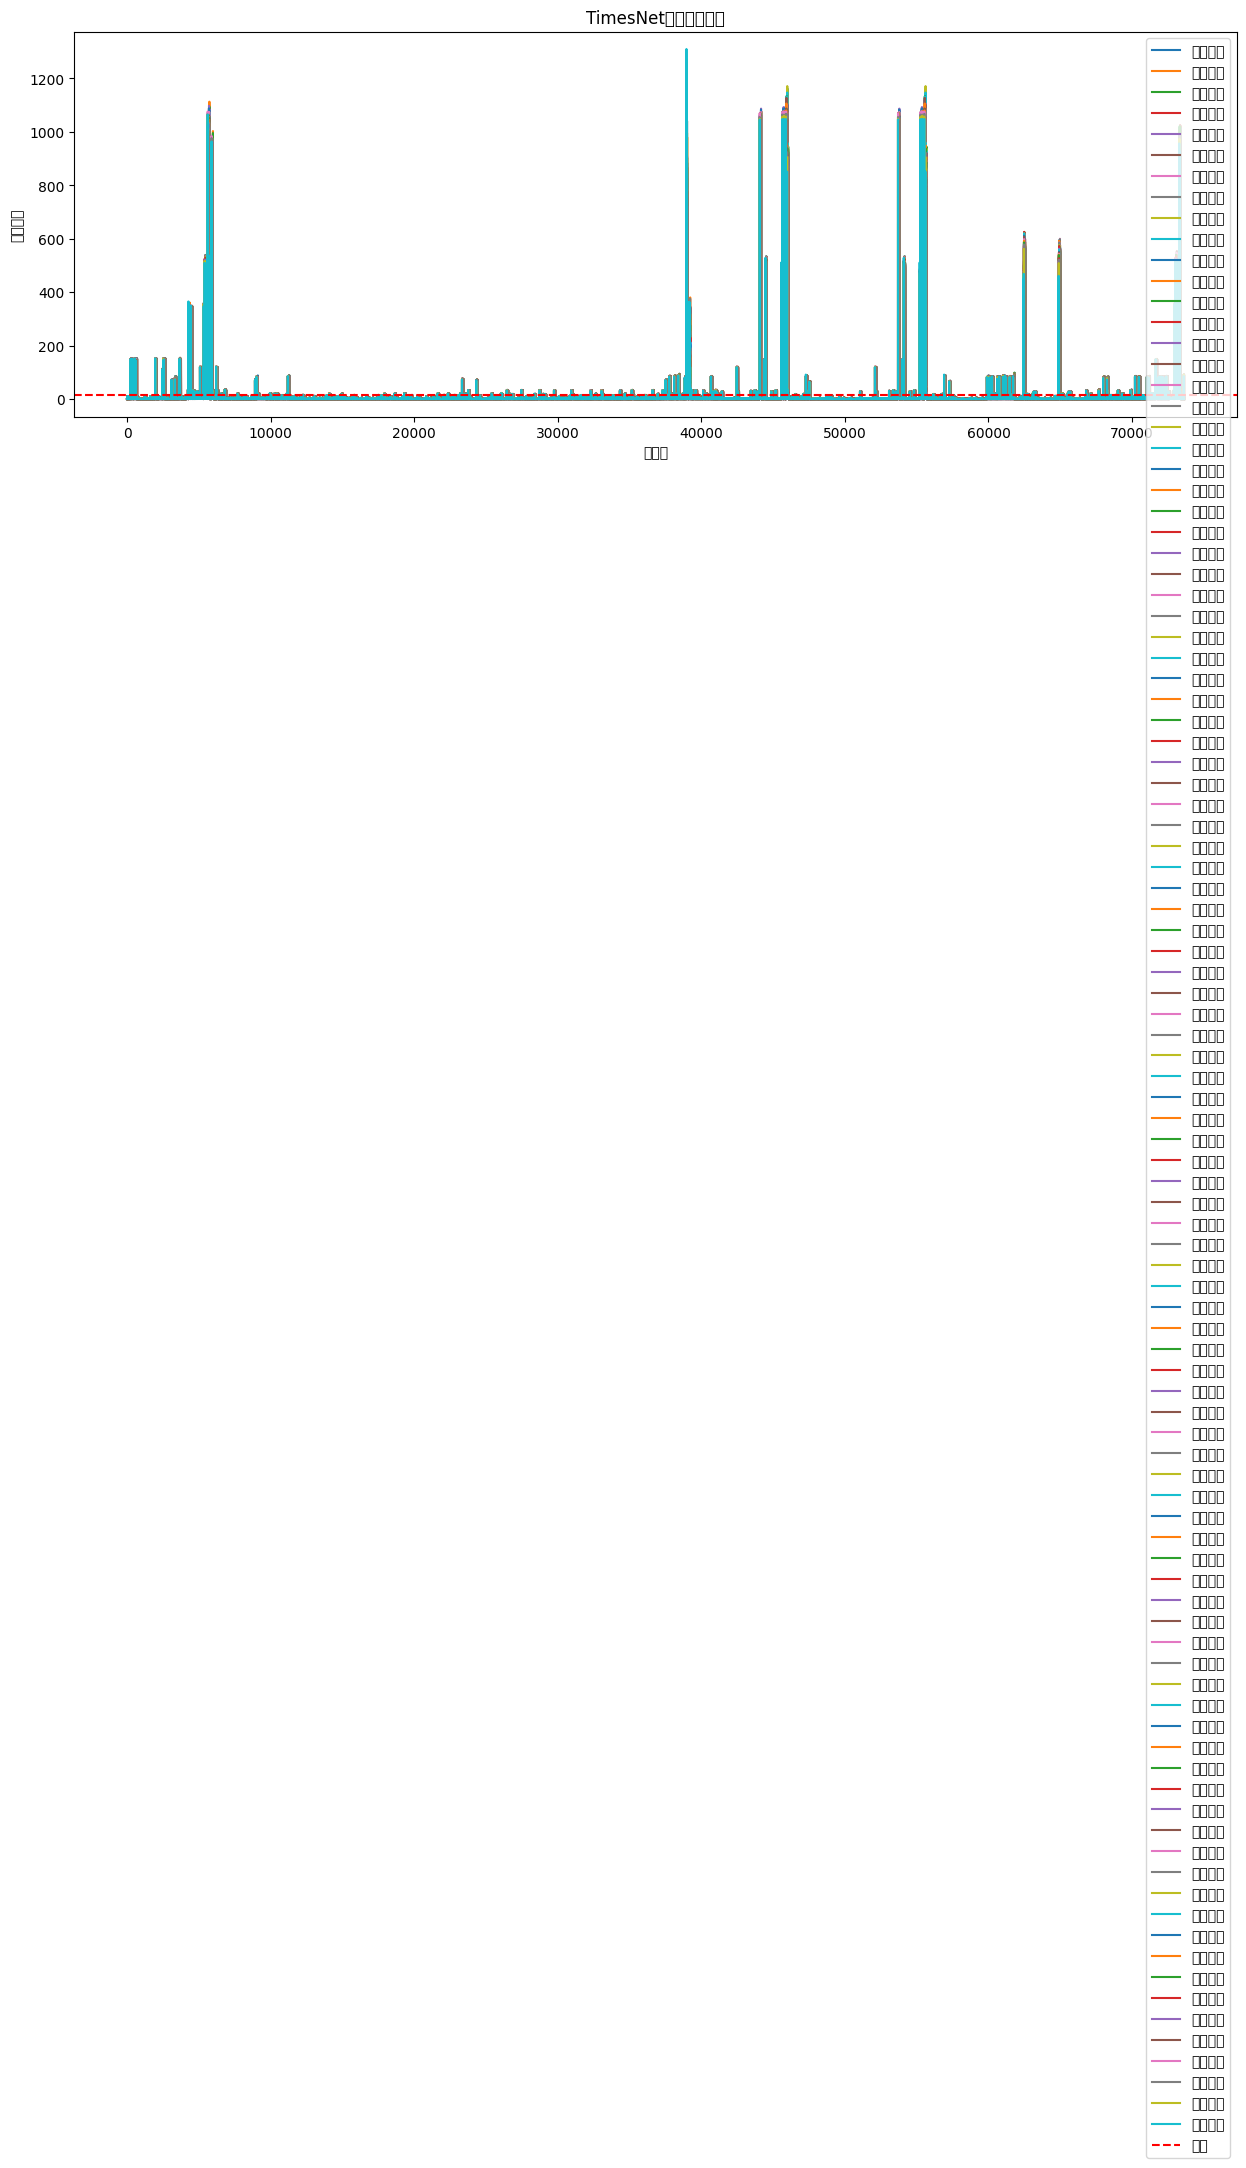

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(test_scores, label='异常分数')
plt.axhline(y=threshold, color='r', linestyle='--', label='阈值')
plt.title('TimesNet异常检测结果')
plt.xlabel('时间步')
plt.ylabel('异常分数')
plt.legend()
plt.show()